In [3]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Path to your dataset directory
train_dir = '/kaggle/input/sugercane-disease-dataset/Sugarcane Leaf Disease Dataset'
healthy_dir = os.path.join(train_dir, 'Healthy')
mosaic_dir = os.path.join(train_dir, 'Mosaic')
red_rot_dir = os.path.join(train_dir, 'RedRot')
rust_dir = os.path.join(train_dir, 'Rust')
yellow_dir = os.path.join(train_dir, 'Yellow')

In [6]:
# Function to read images from a directory
def read_images_from_dir(directory):
    images = []
    for filename in os.listdir(directory):
        img = cv2.imread(os.path.join(directory, filename))
        if img is not None:
            images.append(img)
    return images


In [7]:
# Function to resize images
def resize_images(images, target_size=(299, 299)):
    resized_images = []
    for img in images:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
        resized = cv2.resize(img, target_size)
        resized_images.append(resized)
    return np.array(resized_images)


In [8]:
# Function to normalize images
def normalize_images(images):
    return images.astype('float32') / 255.0


In [9]:
# Read images from each class directory
healthy_images = read_images_from_dir(healthy_dir)
mosaic_images = read_images_from_dir(mosaic_dir)
red_rot_images = read_images_from_dir(red_rot_dir)
rust_images = read_images_from_dir(rust_dir)
yellow_images = read_images_from_dir(yellow_dir)

In [10]:
# Print the number of images in each class
print("Number of Healthy images:", len(healthy_images))
print("Number of Mosaic images:", len(mosaic_images))
print("Number of Red Rot images:", len(red_rot_images))
print("Number of Rust images:", len(rust_images))
print("Number of Yellow images:", len(yellow_images))

Number of Healthy images: 522
Number of Mosaic images: 462
Number of Red Rot images: 518
Number of Rust images: 514
Number of Yellow images: 505


In [12]:
# Number of images in each class
classes = ['Healthy', 'Mosaic', 'Red Rot', 'Rust', 'Yellow']
counts = [len(healthy_images), len(mosaic_images), len(red_rot_images), len(rust_images), len(yellow_images)]

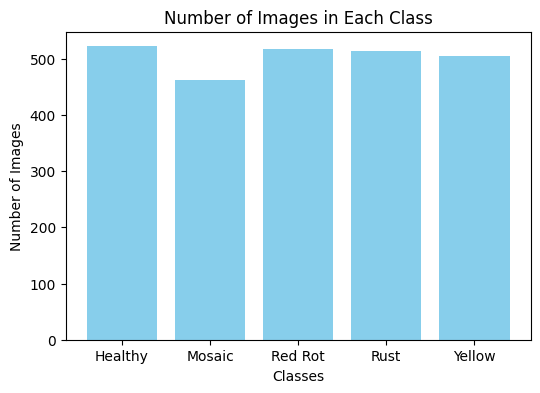

In [13]:
# Create bar graph
plt.figure(figsize=(6, 4))
plt.bar(classes, counts, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.show()


In [14]:
# Resize images for each class
target_size = (299, 299)  # InceptionV3 input size
resized_healthy = resize_images(healthy_images, target_size)
resized_mosaic = resize_images(mosaic_images, target_size)
resized_red_rot = resize_images(red_rot_images, target_size)
resized_rust = resize_images(rust_images, target_size)
resized_yellow = resize_images(yellow_images, target_size)


In [16]:
# Normalize images for each class
normalized_healthy = normalize_images(resized_healthy)
normalized_mosaic = normalize_images(resized_mosaic)
normalized_red_rot = normalize_images(resized_red_rot)
normalized_rust = normalize_images(resized_rust)
normalized_yellow = normalize_images(resized_yellow)

In [17]:
# Delete unnecessary variables to free up memory
del healthy_images, mosaic_images, red_rot_images, rust_images, yellow_images
del resized_healthy, resized_mosaic, resized_red_rot, resized_rust, resized_yellow


In [18]:
# Concatenate images and labels
X = np.concatenate((normalized_healthy, normalized_mosaic, normalized_red_rot,
                    normalized_rust, normalized_yellow), axis=0)
y = np.array([0]*len(normalized_healthy) + [1]*len(normalized_mosaic) +
             [2]*len(normalized_red_rot) + [3]*len(normalized_rust) +
             [4]*len(normalized_yellow))

In [19]:
# Shuffle X and y in unison
rng_state = np.random.get_state()
np.random.shuffle(X)
np.random.set_state(rng_state)
np.random.shuffle(y)

In [20]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Convert labels to categorical (one-hot encoding)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [22]:
# Load InceptionV3 model pre-trained on ImageNet without the top classification layer
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [23]:
# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)  # 5 classes now


In [24]:
# Combine the base model with custom layers
model = Model(inputs=base_model.input, outputs=predictions)

In [25]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

In [26]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/20
 1/57 ━━━━━━━━━━━━━━━━━━━━ 28:32 31s/step - accuracy: 0.1562 - loss: 2.0655

I0000 00:00:1709762206.471989     160 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1709762206.523193     160 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.3039 - loss: 1.6222

W0000 00:00:1709762231.089648     159 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709762237.717467     162 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


57/57 ━━━━━━━━━━━━━━━━━━━━ 74s 779ms/step - accuracy: 0.3053 - loss: 1.6192 - val_accuracy: 0.6584 - val_loss: 1.0981
Epoch 2/20


W0000 00:00:1709762250.220107     159 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - accuracy: 0.5637 - loss: 1.1297 - val_accuracy: 0.6931 - val_loss: 0.9211
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - accuracy: 0.6494 - loss: 0.9581 - val_accuracy: 0.7376 - val_loss: 0.8230
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - accuracy: 0.6818 - loss: 0.8494 - val_accuracy: 0.7129 - val_loss: 0.7515
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 0.7127 - loss: 0.7698 - val_accuracy: 0.7624 - val_loss: 0.7045
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 0.7533 - loss: 0.7254 - val_accuracy: 0.7624 - val_loss: 0.6730
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 0.7646 - loss: 0.6467 - val_accuracy: 0.7624 - val_loss: 0.6410
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 0.7887 - loss: 0.6057 - val_accuracy: 0.7772 - val_loss: 0.6195
Epoch 9/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 0.7925 - loss: 0.5904 - val_accuracy: 0.7574 - val_

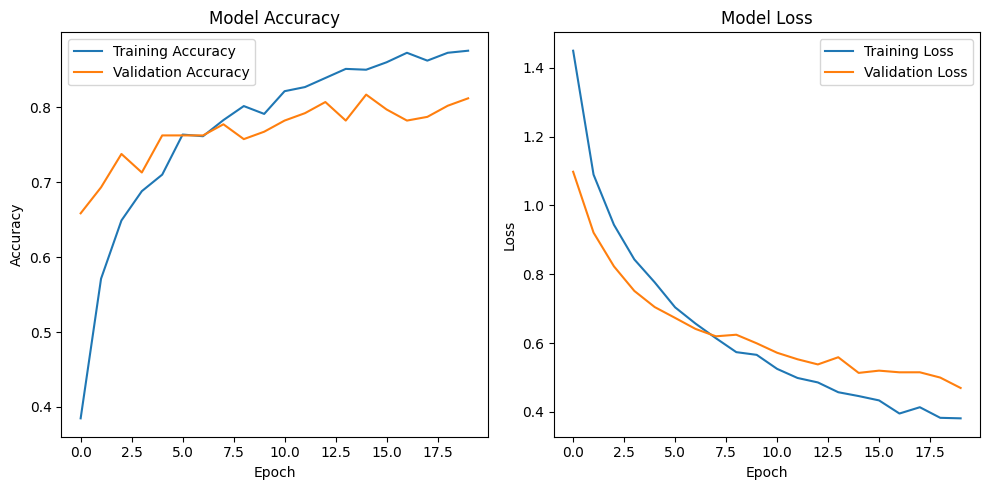

In [29]:
# Plot training & validation accuracy and loss values
plt.figure(figsize=(10, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [28]:
# Evaluate the model on test data
_, accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy:", accuracy)

Accuracy: 0.8356435894966125


W0000 00:00:1709762410.907303     161 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [30]:
# Predict labels
y_pred = np.argmax(model.predict(X_test), axis=-1)
# Convert one-hot encoded labels back to categorical labels
y_true = np.argmax(y_test, axis=-1)
# Calculate precision, recall, F1-score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

 2/16 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step

W0000 00:00:1709762428.142791     159 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 469ms/step


W0000 00:00:1709762435.170206     162 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [31]:
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.8368178039429651
Recall: 0.8356435643564356
F1-score: 0.8360283990863081


In [32]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)


[[100  10   2   0   4]
 [  4  68   6   2   8]
 [  2   2  88   4   7]
 [  0   1   4 101   4]
 [  5   8   8   2  65]]


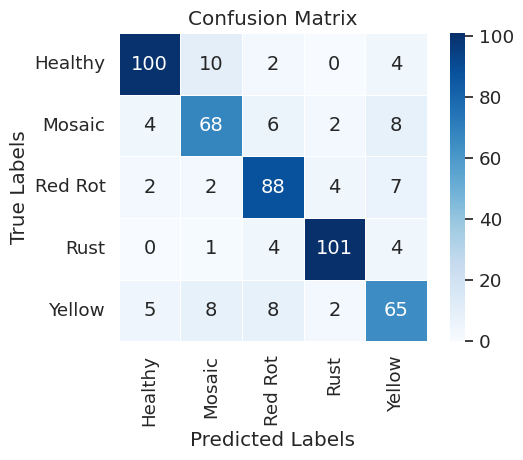

In [33]:
# Labels for the classes
classes = ['Healthy', 'Mosaic', 'Red Rot', 'Rust', 'Yellow']

# Create a heatmap
plt.figure(figsize=(6, 4))
sns.set(font_scale=1.2)  # for label size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, square=True,
            xticklabels=classes, yticklabels=classes, linewidths=.5, annot_kws={"size": 14})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [34]:
# Save the model
model.save('Sugarcane-Model.h5')  # Saves the model to a HDF5 file
